In [ ]:
!pip install open3d numpy matplotlib

In [ ]:
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [ ]:
PCD_PATH   = "cloud.ply"
CELL_SIZE  = 0.05   # 5 cm par pixel sur la carte 2D
TOL_XY     = 0.30   # marge (m) autour d'un segment pour chercher les points 3D
MIN_WALL_H = 0.30   # hauteur mini (m) pour garder un mur

In [ ]:
pcd = o3d.io.read_point_cloud(PCD_PATH)
points = np.asarray(pcd.points)            # shape (N, 3)
assert points.size > 0, "Nuage vide ou chemin incorrect !"

# BBox du nuage (servira plus tard pour le recalage)
cx_min, cy_min = points[:,0].min(), points[:,1].min()
cx_max, cy_max = points[:,0].max(), points[:,1].max()

In [ ]:
x_idx = ((points[:,0] - cx_min) / CELL_SIZE).astype(int)
y_idx = ((points[:,1] - cy_min) / CELL_SIZE).astype(int)

w, h = x_idx.max()+1, y_idx.max()+1
density = np.zeros((h, w), dtype=np.uint32)
for xi, yi in zip(x_idx, y_idx):
    density[yi, xi] += 1

density_norm = (density / density.max() * 255).astype(np.uint8)
IMG_PATH = "projection_densite.png"
plt.imsave(IMG_PATH, density_norm, cmap='gray')

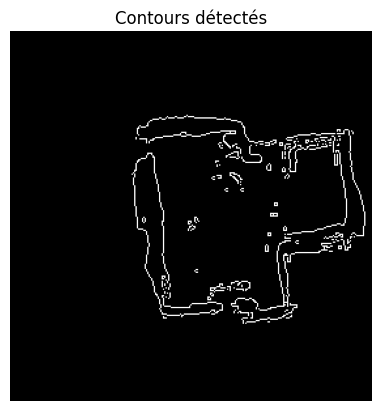

In [ ]:
img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)  # seuil léger
edges = cv2.Canny(binary, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [c.reshape(-1,2) for c in contours if len(c) >= 3]
assert contours, "Aucun contour détecté – ajuster le seuillage si besoin."

# (optionnel) aperçu rapide
plt.imshow(edges, cmap='gray'); plt.title("Contours détectés"); plt.axis('off'); plt.show()

In [ ]:
img_h, img_w = img.shape
sx = (cx_max - cx_min) / img_w
sy = (cy_max - cy_min) / img_h

contours_m = []
for c in contours:
    c_m = np.empty_like(c, dtype=np.float64)
    c_m[:,0] = c[:,0] * sx + cx_min
    # inversion verticale de l’axe Y de l’image
    c_m[:,1] = (img_h - c[:,1]) * sy + cy_min
    contours_m.append(c_m)


In [ ]:
def wall_height(x1, y1, x2, y2, pts, tol=TOL_XY):
    x_min, x_max = min(x1,x2)-tol, max(x1,x2)+tol
    y_min, y_max = min(y1,y2)-tol, max(y1,y2)+tol
    mask = (pts[:,0] >= x_min) & (pts[:,0] <= x_max) & \
           (pts[:,1] >= y_min) & (pts[:,1] <= y_max)
    seg_pts = pts[mask]
    if seg_pts.size == 0:
        return 0.0
    z_vals = seg_pts[:,2]
    return z_vals.max() - z_vals.min()

In [ ]:
vertices, triangles = [], []
index = 0

for contour in contours_m:
    for i in range(len(contour)-1):
        x1,y1 = contour[i]
        x2,y2 = contour[i+1]

        h = wall_height(x1, y1, x2, y2, points)
        if h < MIN_WALL_H:
            continue                        # on ignore les segments trop bas

        # quatre coins du mur
        v0 = [x1, y1, 0]
        v1 = [x2, y2, 0]
        v2 = [x2, y2, h]
        v3 = [x1, y1, h]

        vertices += [v0, v1, v2, v3]
        triangles.append([index,   index+1, index+2])
        triangles.append([index,   index+2, index+3])
        index += 4

print(" Sommets créés :", len(vertices))
print(" Triangles créés :", len(triangles))

assert vertices, "Aucun mur n’a été créé – vérifier CELL_SIZE, TOL_XY ou MIN_WALL_H."

mesh = o3d.geometry.TriangleMesh()
mesh.vertices  = o3d.utility.Vector3dVector(np.array(vertices))
mesh.triangles = o3d.utility.Vector3iVector(np.array(triangles))
mesh.compute_vertex_normals()

MESH_PATH = "mur3D_hauteur_reelle.ply"
o3d.io.write_triangle_mesh(MESH_PATH, mesh)
print(" Mesh exporté :", os.path.abspath(MESH_PATH))

 Sommets créés : 4864
 Triangles créés : 2432
 Mesh exporté : /content/mur3D_hauteur_reelle.ply


In [ ]:
try:
    import plotly.graph_objects as go
    v = np.asarray(mesh.vertices)
    t = np.asarray(mesh.triangles)
    fig = go.Figure(data=[
        go.Mesh3d(
            x=v[:,0], y=v[:,1], z=v[:,2],
            i=t[:,0], j=t[:,1], k=t[:,2],
            color='lightblue', opacity=0.6
        )
    ])
    fig.update_layout(scene=dict(aspectmode='data'),
                      title="Mur 3D (hauteurs réelles)")
    fig.show()
except Exception as e:
    print("Plotly non installé ou erreur de rendu :", e)
